# Logo Detection - Export Model to ONNX

## Import Libraries

In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator

In [2]:
root_dir = Path.cwd().parent.parent
root_dir

PosixPath('/mnt/d/Projects_D/Brand_Extractor')

## Model Data

In [3]:
model_dir = root_dir / 'training_history' / 'yolov8' / 'logos'
model_dir

PosixPath('/mnt/d/Projects_D/Brand_Extractor/training_history/yolov8/logos')

In [4]:
model_checkpoint = model_dir / 'weights' / 'best.pt'
model_checkpoint

PosixPath('/mnt/d/Projects_D/Brand_Extractor/training_history/yolov8/logos/weights/best.pt')

## Load Model

In [5]:
model = YOLO(model_checkpoint)

In [6]:
model.info()

Model summary: 295 layers, 25856899 parameters, 0 gradients, 79.1 GFLOPs


(295, 25856899, 0, 79.0656)

## Visualize Results

In [7]:
def plot_bboxes(r):
    annotator = Annotator(r.orig_img)
    boxes = r.boxes
    for box in boxes:
        b = box.xyxy[0]
        c = box.cls
        annotator.box_label(b, model.names[int(c)])
    img = annotator.result()
    return img

In [18]:
sample_image = root_dir / 'data' / 'logo_detection' / 'test' / 'images' / 'img000003_103.jpg'
sample_image

PosixPath('/mnt/d/Projects_D/Brand_Extractor/data/logo_detection/test/images/img000003_103.jpg')

In [19]:
results = model(sample_image)


image 1/1 /mnt/d/Projects_D/Brand_Extractor/data/logo_detection/test/images/img000003_103.jpg: 480x640 1 logo, 101.1ms
Speed: 2.9ms preprocess, 101.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


In [20]:
len(results)

1

1


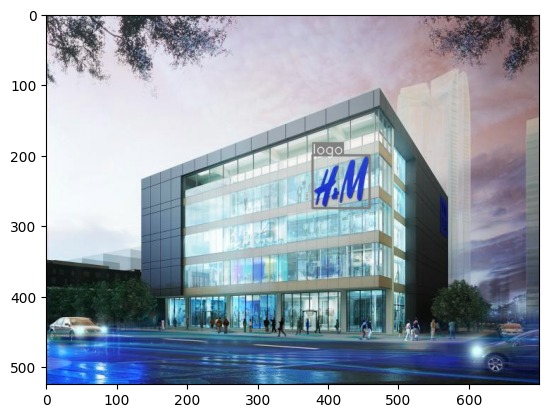

In [21]:
for result in results:
    img = plot_bboxes(result)
    plt.imshow(img)
    plt.show()

## Export Model to ONNX

In [35]:
onnx_model = model.export(format='onnx')

Ultralytics YOLOv8.1.47 🚀 Python-3.10.14 torch-2.2.2+cu121 CPU (11th Gen Intel Core(TM) i7-11800H 2.30GHz)

PyTorch: starting from '/mnt/d/Projects_D/Brand_Extractor/training_history/yolov8/logos/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (49.6 MB)

ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: export success ✅ 2.1s, saved as '/mnt/d/Projects_D/Brand_Extractor/training_history/yolov8/logos/weights/best.onnx' (98.8 MB)

Export complete (4.0s)
Results saved to /mnt/d/Projects_D/Brand_Extractor/training_history/yolov8/logos/weights
Predict:         yolo predict task=detect model=/mnt/d/Projects_D/Brand_Extractor/training_history/yolov8/logos/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=/mnt/d/Projects_D/Brand_Extractor/training_history/yolov8/logos/weights/best.onnx imgsz=640 data=/mnt/d/Projects_D/Brand_Extractor/data/logo_detection/logo_detection.yaml  
Visualize:       https://netron.app
